In [4]:
import numpy as np
import pandas as pd
from scipy.fft import fft, ifft
from scipy.interpolate import interp1d
from scipy.stats import entropy, iqr, kurtosis, mode, skew
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import (Activation, BatchNormalization, Bidirectional,
                                     Conv1D, Conv2D, Dense, Dropout,
                                     Flatten, GlobalAveragePooling1D, LSTM,
                                     MaxPool1D, MaxPooling2D, Reshape,
                                     TimeDistributed)
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import os
import pickle
from pandas import read_csv, unique
from scipy.signal import argrelextrema, butter, find_peaks, lfilter, lfilter_zi
from tensorflow import keras
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_accuracy
from kerastuner import RandomSearch, Hyperband
import kerastuner


In [58]:
X_respeck = pickle.load(open("X_respeck_resp_other", "rb"))
y_respeck = pickle.load(open("y_respeck_resp_other", "rb"))
y_respeck_phys = [[x[0].split('|')[0]] for x in y_respeck] # get only physical activities
y_respeck = [x[0].split('|') for x in y_respeck] # get only subactivities

print(np.unique(y_respeck))
y_respeck_task2 = []
for i in range(len(y_respeck)):
    if y_respeck[i][0] in ['normal', 'hyperventilating', 'coughing']:
        y_respeck_task2.append(y_respeck[i][0])
    else:
        y_respeck_task2.append('other')     
y_respeck_task2 = np.array(y_respeck_task2).reshape(-1,1)
enc = OneHotEncoder(handle_unknown='ignore')
print(np.unique(y_respeck_task2))
enc_fitted = enc.fit(y_respeck_task2)
print(enc_fitted.categories_)
y_respeck_task2 = enc.transform(y_respeck_task2).toarray()
print(enc_fitted.categories_)# One Hot is inexed as this array prints!!!!!
y_respeck_task2 = np.array(y_respeck_task2)


X_respeck_task3 = []
y_respeck_task3 = []
for i in range(len(y_respeck)):
    if not y_respeck[i][0] in ['normal', 'hyperventilating', 'coughing']:
        X_respeck_task3.append(X_respeck[i])
        y_respeck_task3.append(y_respeck[i][0])
y_respeck_task3 = np.array(y_respeck_task3).reshape(-1,1)
enc_fitted = enc.fit(y_respeck_task3)
enc_fitted.categories_
print(np.unique(y_respeck_task3))
X_respeck_task3 = np.array(X_respeck_task3)
y_respeck_task3 = enc.transform(y_respeck_task3).toarray()
print(enc_fitted.categories_)# One Hot is inexed as this array prints!!!!!
print(X_respeck_task3.shape)

['coughing' 'eating' 'hyperventilating' 'laughing' 'normal' 'singing'
 'talking']
['eating' 'laughing' 'singing' 'talking']
[array(['eating', 'laughing', 'singing', 'talking'], dtype='<U8')]
(26053, 50, 10)


In [34]:
# X_train, X_temp, y_train, y_temp = train_test_split(X_respeck, y_respeck_task2, test_size=0.2, random_state=42)
# X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [59]:
X_train, X_temp, y_train, y_temp = train_test_split(X_respeck_task3, y_respeck_task3, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [60]:
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('lstm_units1', min_value=16, max_value=156, step=16), return_sequences=True, input_shape=X_train[0].shape, activation='relu'))
    model.add(LSTM(units=hp.Int('lstm_units2', min_value=16, max_value=256, step=16), return_sequences=True, activation='relu'))
    model.add(Conv1D(filters=hp.Int('conv1d_filters1', min_value=16, max_value=256, step=16), kernel_size=hp.Int('conv1d_kernel_size1', min_value=2, max_value=5), activation='relu', strides=2))
    model.add(MaxPool1D(pool_size=hp.Int('maxpool1d_pool_size', min_value=2, max_value=5), padding='same'))
    model.add(Conv1D(filters=hp.Int('conv1d_filters2', min_value=16, max_value=256, step=16), kernel_size=hp.Int('conv1d_kernel_size2', min_value=2, max_value=5), activation='relu', strides=1))
    model.add(GlobalAveragePooling1D())
    model.add(BatchNormalization(epsilon=1e-06))
    model.add(Dense(y_train.shape[1], activation='softmax'))

    # Compile the model with tunable hyperparameters
    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
        loss=categorical_crossentropy,
        metrics=['categorical_accuracy']
    )
    
    return model

In [61]:
from kerastuner.tuners import BayesianOptimization

# tuner = Hyperband(
#     build_model,
#     factor=3,  # Reduction factor for the number of models in each bracket
#     max_epochs=20,  # Maximum number of training epochs for each model
#     objective='categorical_accuracy',  # The metric to optimize
#     directory='tuner_dir',  # Directory to store results
#     project_name='cnn_lstm_task_no_pre', # Name of the tuning project
# )

tuner = Hyperband(
    build_model,
    factor=3,  # Reduction factor for the number of models in each bracket
    max_epochs=20,  # Maximum number of training epochs for each model
    objective='categorical_accuracy',  # The metric to optimize
    directory='tuner_dir',  # Directory to store results
    project_name='task3_task3_sub_hb'  # Name of the tuning project
)



INFO:tensorflow:Reloading Oracle from existing project tuner_dir/task3_task3_sub_hb/oracle.json


In [62]:
tuner.search(X_train, y_train, validation_data=(X_val, y_val), batch_size=64, shuffle=False)

Trial 30 Complete [00h 11m 12s]
categorical_accuracy: 0.7042510509490967

Best categorical_accuracy So Far: 0.7042510509490967
Total elapsed time: 02h 21m 16s
INFO:tensorflow:Oracle triggered exit


In [63]:
best = tuner.get_best_models()[0]

In [69]:
best.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/50
326/326 [==============================] - 36s 110ms/step - loss: 0.2648 - categorical_accuracy: 0.8911 - val_loss: 0.4646 - val_categorical_accuracy: 0.8181
Epoch 2/50
326/326 [==============================] - 39s 120ms/step - loss: 0.2660 - categorical_accuracy: 0.8896 - val_loss: 0.4681 - val_categorical_accuracy: 0.8250
Epoch 3/50
326/326 [==============================] - 38s 117ms/step - loss: 0.2626 - categorical_accuracy: 0.8908 - val_loss: 0.4838 - val_categorical_accuracy: 0.8081
Epoch 4/50
326/326 [==============================] - 34s 104ms/step - loss: 0.2579 - categorical_accuracy: 0.8931 - val_loss: 0.4851 - val_categorical_accuracy: 0.8093
Epoch 5/50
326/326 [==============================] - 29s 88ms/step - loss: 0.2525 - categorical_accuracy: 0.8968 - val_loss: 0.4879 - val_categorical_accuracy: 0.8112
Epoch 6/50
326/326 [==============================] - 32s 97ms/step - loss: 0.2415 - categorical_accuracy: 0.9021 - val_loss: 0.5301 - val_categorical_accur

In [70]:
# ran task 3 task 3 sub with a further 100 epochs - 120 total
with open('Task3_Task3.json', 'w') as f:
    f.write(best.to_json())
best.save('Trained_Task3_Task3.keras')

In [71]:
best.evaluate(X_test, y_test)

82/82 [==============================] - 4s 46ms/step - loss: 0.4939 - categorical_accuracy: 0.8464


[0.493854820728302, 0.8464491367340088]

82/82 [==============================] - 4s 46ms/step
[9.0607780e-01 4.0921327e-07 2.0585076e-05 9.3901075e-02]
[1. 0. 0. 0.]


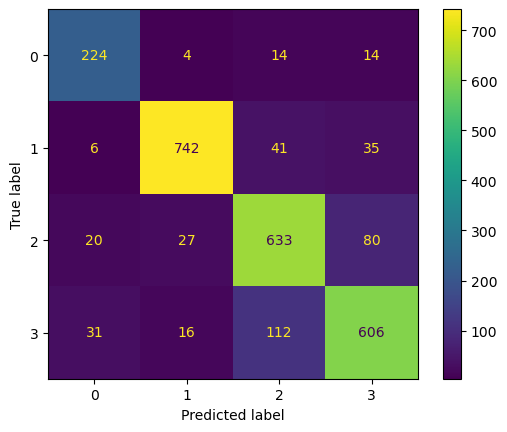

In [72]:

predictions = best.predict(X_test)
print(predictions[0])
print(y_test[0])
cm = confusion_matrix(np.argmax(y_test, axis =1), np.argmax(predictions, axis =1))
cm_disp = ConfusionMatrixDisplay(confusion_matrix= cm)
cm_disp.plot()
plt.show()

In [68]:
best.evaluate(X_test, y_test)

82/82 [==============================] - 2s 26ms/step - loss: 0.5052 - categorical_accuracy: 0.8157


[0.5052124857902527, 0.8157389760017395]

In [9]:
task1 = keras.models.load_model('Trained_Task1.keras')
task2_others = keras.models.load_model('Trained_Task2_others.keras')
task3 = keras.models.load_model('Trained_Task3_Task3.keras')

2023-11-03 10:44:00.787691: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-11-03 10:44:00.787857: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-11-03 10:44:00.787902: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (dan-HP-ENVY-x360-Convertible-13-ay0xxx): /proc/driver/nvidia/version does not exist
2023-11-03 10:44:00.788322: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
def predict_task3(X):
    physical_action = task1.predict(X)
    physical_action = np.argmax(physical_action, axis=1)
    prediction_labels = ['ascending stairs', 'descending stairs', 'lying down back',
        'lying down on left', 'lying down on stomach', 'lying down right',
        'miscellaneous movements', 'normal walking', 'running',
        'shuffle walking', 'sitting', 'standing']
    physical_prediction = [prediction_labels[i] for i in physical_action]
    subtype_prediction = task3.predict(X)
    subtype_prediction = np.argmax(subtype_prediction, axis=1)
    
predict_task3(X_test)

180/180 [==============================] - 5s 26ms/step
lying down on left
